In [39]:
# 1. Import thư viện cần thiết
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam, Adamax, Ftrl

In [40]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_excel('/kaggle/input/bnb-data/bnb_processed_data.xlsx')
df1=df.reset_index()['Close']

In [41]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [42]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [43]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [44]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
# X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [45]:
ytest.shape

(475,)

In [46]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [47]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0926 - val_loss: 0.0153
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0070 - val_loss: 0.0021
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

In [49]:
# 10. Dự báo dữ liệu test, val
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [50]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
# y_pred_val = scaler.inverse_transform(y_pred_val)

In [51]:
# EVALUATION
from sklearn.metrics import mean_squared_error, mean_absolute_error
test_rmse = np.sqrt(mean_squared_error(ytest, y_pred))

test_mse = mean_squared_error(ytest, y_pred)

test_mae = mean_absolute_error(ytest, y_pred)

test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

print(f"Testing RMSE: {test_rmse}")
print(f"Testing MSE: {test_mse}")
print(f"Testing MAE: {test_mae}")
print(f"Testing MAPE: {test_mape}%")

Testing RMSE: 357.07119232644027
Testing MSE: 127499.83638942568
Testing MAE: 334.74359984735037
Testing MAPE: 78385.05979154861%


<h2> 30 days

In [52]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while(i < 30):

    if(len(temp_input) > n_steps):
        # Ensure only the last 100 elements are used
        x_input = np.array(temp_input[-100:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # Predict the next value
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        # Remove the first element to maintain the size of 100
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i = i + 1

# print(lst_output)

0 day input [0.55924481 0.54920325 0.55884414 0.56906318 0.58871229 0.57873439
 0.60991559 0.58591298 0.59796771 0.60273301 0.60782863 0.61481403
 0.57823327 0.62978711 0.69924355 0.71845946 0.72066216 0.78041459
 0.77042396 0.79315809 0.93227844 0.89089661 0.93564248 0.85155461
 0.84301543 0.81820905 0.7469488  0.82142588 0.81624461 0.8140389
 0.81419041 0.83837673 0.86754205 0.85662036 0.84815731 0.8613035
 0.90540851 0.88793645 0.89677975 0.85098648 0.81239233 0.82940903
 0.86456128 0.85484399 0.86534962 0.86255113 0.86675161 0.85764064
 0.90154532 0.89375583 0.88097825 0.81782285 0.83721153 0.81568373
 0.79310349 0.78798066 0.81462955 0.81870755 0.84282773 0.85582406
 0.89477895 0.8966777  0.89854696 0.9074302  0.88296733 0.8799883
 0.88651788 0.87565198 0.85412527 0.82849135 0.82716841 0.86691594
 0.86516916 0.87461512 0.86911543 0.85262169 0.86869745 0.88045575
 0.86483242 0.87444629 0.87804328 0.8738145  0.83644399 0.8595077
 0.84017087 0.85816296 0.85711658 0.84833749 0.8873360

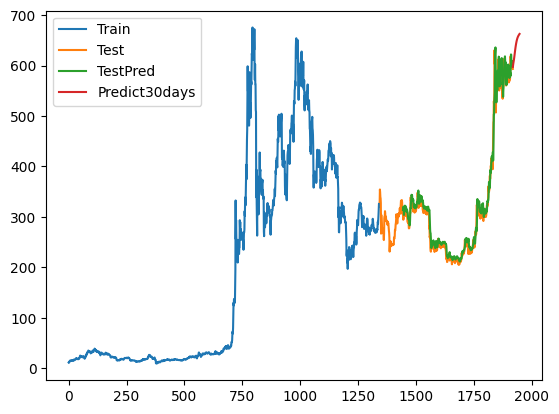

In [53]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)

plt.plot(test_data_index,(y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','TestPred','Predict30days'])
plt.show()

<h2> 60 days

In [54]:
# 14. Dự báo 60 ngày tiếp theo
x_input = test_data[60:].reshape(1,-1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<60):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[-100:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.55924481 0.54920325 0.55884414 0.56906318 0.58871229 0.57873439
 0.60991559 0.58591298 0.59796771 0.60273301 0.60782863 0.61481403
 0.57823327 0.62978711 0.69924355 0.71845946 0.72066216 0.78041459
 0.77042396 0.79315809 0.93227844 0.89089661 0.93564248 0.85155461
 0.84301543 0.81820905 0.7469488  0.82142588 0.81624461 0.8140389
 0.81419041 0.83837673 0.86754205 0.85662036 0.84815731 0.8613035
 0.90540851 0.88793645 0.89677975 0.85098648 0.81239233 0.82940903
 0.86456128 0.85484399 0.86534962 0.86255113 0.86675161 0.85764064
 0.90154532 0.89375583 0.88097825 0.81782285 0.83721153 0.81568373
 0.79310349 0.78798066 0.81462955 0.81870755 0.84282773 0.85582406
 0.89477895 0.8966777  0.89854696 0.9074302  0.88296733 0.8799883
 0.88651788 0.87565198 0.85412527 0.82849135 0.82716841 0.86691594
 0.86516916 0.87461512 0.86911543 0.85262169 0.86869745 0.88045575
 0.86483242 0.87444629 0.87804328 0.8738145  0.83644399 0.8595077
 0.84017087 0.85816296 0.85711658 0.84833749 0.8873360

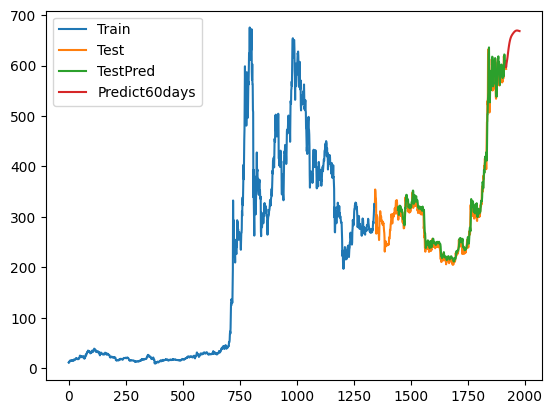

In [55]:
# 15.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','TestPred','Predict60days'])
plt.show()

<h2> 90 days

In [56]:
# 16. Dự báo 90 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[-100:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.55924481 0.54920325 0.55884414 0.56906318 0.58871229 0.57873439
 0.60991559 0.58591298 0.59796771 0.60273301 0.60782863 0.61481403
 0.57823327 0.62978711 0.69924355 0.71845946 0.72066216 0.78041459
 0.77042396 0.79315809 0.93227844 0.89089661 0.93564248 0.85155461
 0.84301543 0.81820905 0.7469488  0.82142588 0.81624461 0.8140389
 0.81419041 0.83837673 0.86754205 0.85662036 0.84815731 0.8613035
 0.90540851 0.88793645 0.89677975 0.85098648 0.81239233 0.82940903
 0.86456128 0.85484399 0.86534962 0.86255113 0.86675161 0.85764064
 0.90154532 0.89375583 0.88097825 0.81782285 0.83721153 0.81568373
 0.79310349 0.78798066 0.81462955 0.81870755 0.84282773 0.85582406
 0.89477895 0.8966777  0.89854696 0.9074302  0.88296733 0.8799883
 0.88651788 0.87565198 0.85412527 0.82849135 0.82716841 0.86691594
 0.86516916 0.87461512 0.86911543 0.85262169 0.86869745 0.88045575
 0.86483242 0.87444629 0.87804328 0.8738145  0.83644399 0.8595077
 0.84017087 0.85816296 0.85711658 0.84833749 0.8873360

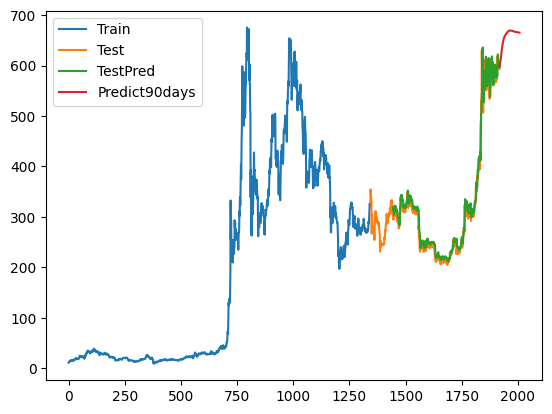

In [57]:
# 17.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','TestPred','Predict90days'])
plt.show()